In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from random import seed
from random import randrange
import seaborn as sns

In [2]:
# Lectura de datos
data = sns.load_dataset('iris')
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# Cambiar ajuste de datos para clasificar setosa
data['categoria'] = [1 if x =='setosa' else -1 for x in data['species']] 

In [4]:
# Función clasifica
def clasifica(x, y, theta, theta_0):
    
    """ Def: evalua la prediccion
    Inputs:
    theta: vector
    theta_0: escalar
    x: vector de caracteristicas
    y: vector de etiquetas

    Outputs:
    value: -1 si la clasific es incorrecta, 0 si lo es
    """
    
    if y*(np.dot(theta,np.transpose(x)) + theta_0) < 1 :
        value = -1
    else:
        value = 0

    return value

In [5]:
def loess(x, y, theta, theta_0):
    """ Evaluacion en la funcion de perdida
    
    Inputs:
    x - vector de características
    y - vector de etiquetas
    theta - vector
    theta_0 - escalar

    Outputs:
    suma = funcion perdida evaluada
    """
    
    suma = 0
    H = 0
    n = x.shape[0]
    
    for i in range(n):
        H = y[i]*(np.dot(theta, x[i]) + theta_0)
        if H >= 1:
            suma += 0
        else:
            suma += (1-H)
            
    return suma

In [6]:
def jacob(X, Y, theta, theta_0, lamb):
    """ Calculo del jacobiano
    
    X - matriz de características
    Y - vector de etiquetas
    theta - vector
    theta0 - escalar
    lamb - escalar

    Outputs:
    value = valor del jacobiano
     """
    
    n = X.shape[0]
    jac = loess(X, Y, theta, theta_0)/n + (lamb/2.0)*np.linalg.norm(theta)

    return jac

In [22]:
# Función para descenso por gradiente
def SVM(X, Y, theta, theta_0, etha, lamb, eps = 1e-8, MAX = 3000):
    """ Support Vector Machine (SVM) utilizando el metodo de descenso en gradiente
    
    Inputs:
    X - matriz de características
    Y - vector de etiquetas
    theta - vector inicial
    theta_0 - escalar
    etha - escalar
    lamb - escalar
    
    Outputs:
    theta = hiperplano final
    theta_0 = base del hiperplano final
    """
    
    n = X.shape[0]
    sum_theta = 0
    sum_theta_0 = 0
    error = 10
    t = 0
    
    while error >= eps and t < MAX:
        # Guardar parametros en tiempo: t-1
        theta_old = theta
        theta_0_old = theta_0
        
        # Evaluacion de la suma para la actualizacion el descenso por gradiente
        for i in range(n):
            sum_theta += clasifica(X[i], Y[i], theta, theta_0)*Y[i]*X[i]
            sum_theta_0 += clasifica(X[i], Y[i], theta, theta_0)*Y[i]
        
        # Descenso por gradiente
        theta = theta - etha*((sum_theta/n) + lamb*theta)
        theta_0= theta_0 - etha*((sum_theta_0/n))
        
        # Calculo del error
        error = abs(jacob(X, Y, theta, theta_0, lamb) - jacob(X, Y, theta_old, theta_0_old, lamb))
        t += 1
    
    jac = jacob(X, Y, theta, theta_0, lamb)
    return theta, theta_0

In [24]:
def CV_SVM(D, k, theta, theta_0, etha, lamb):
    """ Funcion que realiza la validación cruzada para determinar con que hiperprámetros se minimiza el error
    
    Inputs:
    df - Data frame del conjunto de entrenamiento
    k - El número de subcojunto de datos en el cual se desea dividir el set de train
    theta_ - Hiperparametro de iniciacion para la funcion de SVM
    theta0: - Hiperparametro de iniciacion para la funcion de SVM
    eta - Hiperparametro para la funcion de SVM
    lambda_ - Hiperparametro para la funcion de SVM

    Outputs:
    resultados - Error promedio de clasificacion
    
    """
    
    errors = []
    n = D.shape[0]  # Para saber el número de renglones totales
    n = int((n / k))  # Si k = 5 los chunks tienen 24 observaciones  
    for i in range (0,k):
        
        init = n*i
        fin = n*(i+1)
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        
        X_train = train_i.iloc[:,0:4]
        X_train = X_train.to_numpy()
        Y_train = train_i.iloc[:,5]
        Y_train = Y_train.to_numpy()
        theta,theta_0 = SVM(X = X_train, Y = Y_train, theta = theta , theta_0 = theta_0, etha = etha, lamb = lamb)
        
        #Se calcula el error en esa primer corrida
        
        X_test = test_i.iloc[:,0:4]
        X_test = X_test.to_numpy()
        Y_test = test_i.iloc[:,5]
        Y_test = Y_test.to_numpy()
        error_i = error(X = X_test, Y = Y_test, theta = theta, theta_0 = theta_0)
        errors.append(error_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

In [9]:
def error(X, Y, theta, theta_0):
    """ Evaluacion del error
    
    Inputs:
    X - vector de caracteristicas numericas
    Y - vector de etiquetas de las características (-1 o 1)
    theta = vector
    theta_0 = escalar
    
    Outputs:
    error_prom - error promedio de las observaciones que son mal clasificadas
    
    """
    
    n = len(X)
    suma = 0
    error_prom = 0
    
    X = np.squeeze(np.asarray(X))
    Y = np.squeeze(np.asarray(Y))
    
    for i in np.arange(n):
        clasificador = Y[i]*((np.dot(theta,X[i])) + theta_0)
        if clasificador <= 0:
            suma += 1         
    error_prom += suma
    
    error_prom = error_prom/n
    
    return error_prom

In [10]:
def SGD(X, Y, lamb, eps = 1e-8, T = 5000):
    """ Funcion que los parámetros del modelo perceptron 
    Inputs:
    X_array - arreglo de caracteristicas numericas
    y_array - arreglo etiquetas de las características (-1 o 1)
    Nota: se asume que X y y tienen la misma cantidad de registros
    
    T -  Número de iteraciones
    lambda_ - Párametro lambda 
    
    Outputs:
    theta_t - parámetro theta e intercepto (theta_t[-1])
    
    """
    
    n = X.shape[0]
    X = np.matrix(X)
    ones = np.matrix(np.ones((X.shape[0],1)))
    X = np.append(X, ones, axis=1)
    Y = np.matrix(Y).reshape(Y.shape[0],1)
    theta_t = np.matrix(np.zeros(X.shape[1]))
    
    for t in range(T):
        i = np.random.randint(n)
        etha = 1/(t+1)
        theta_t = np.squeeze(np.asarray(theta_t))
        x_i = np.squeeze(np.asarray(X[i]))
        
        if np.dot(theta_t,x_i)*Y[i] < 1:
            l_h =  -1
        else:
            l_h =  0
        
        theta_t = theta_t - etha*(l_h*Y[i]*x_i + (lamb)*theta_t)
        
    return np.array(theta_t)

In [11]:
def CV_SGD(D, k, lamb):
    """ Funcion que realiza la validación cruzada para determinar con que hiperprámetros se minimiza el error
    Inputs:
    df - Data frame del conjunto de entrenamiento
    k - El número de subcojunto de datos en el cual se desea dividir el set de train

    Outputs:
    resultados - Un data frame que arroja los errores para cada k 
    """
    
    errors = []
    n = D.shape[0]
    n = int((n / k))
    
    for i in range (0,k):
        init = n*i
        fin = n*(1+i)
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        
        # Calcular theta y theta_0 con SGD y train
        X = train_i.iloc[:,0:4]
        Y = train_i.iloc[:,5]
        theta_t = SGD(X = X, Y = Y, lamb = lamb)
        theta = theta_t[0,0:-1]
        theta_0 = theta_t[0,-1]
        
        #Se calcula el error en esa primer corrida
        X = test_i.iloc[:,0:4]   #Columna con las 4 características
        Y = test_i.iloc[:,5]    #Columna con el vector de etiquetas
        e_i = error(X = X, Y = Y, theta = theta, theta_0 = theta_0)
        errors.append(e_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

In [12]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

In [13]:
# Probar SGD
error_sgd = []
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_sgd.append(CV_SGD(D = train, k = 5, lamb = lamb))

print(error_sgd)

[0.0, 0.0, 0.0, 0.0, 0.0]


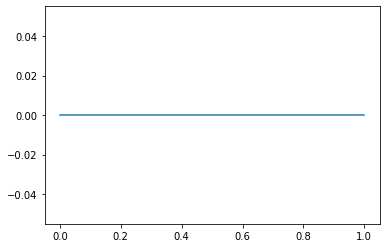

In [14]:
plt.plot((lambdas), (error_sgd))

In [15]:
np.random.seed(2020)
theta_t = SGD(X = test.iloc[:,0:4], Y = test.iloc[:,5], lamb = 0.001, T=1000)
theta_SGD = theta_t[0,0:-1]
theta_0_SGD = theta_t[0,-1]
print(theta_SGD)
print(theta_0_SGD)

[ 0.07138148  1.53862499 -1.81551524 -0.64653109]
0.2478660096278402


In [36]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

# Extraer variables para la clasificación
data_vars = train.iloc[:,0:4]
vars_train = data_vars.to_numpy()
data_labels = train.iloc[:,5]
labels_train = data_labels.to_numpy()

test_vars = test.iloc[:,0:4]
vars_test = test_vars.to_numpy()
test_labels = test.iloc[:,5]
labels_test = test_labels.to_numpy()


theta = np.array([0.0, 0.0, 0.0, 0.0])
theta_0 = 0.0
etha = 0.0001
lamb = 0.0001

In [25]:
error_SVM=[]
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_SVM.append(CV_SVM(D = train, k = 5, theta = theta, theta_0 = theta_0, etha = etha, lamb = lamb))
print(error_SVM)

[0.0, 0.0, 0.0, 0.0, 0.008333333333333333]


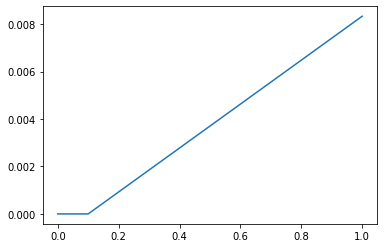

In [27]:
plt.plot(lambdas, error_SVM)

In [35]:
theta_SVM, theta_0_SVM = SVM(X = vars_train, Y = labels_train, 
                             theta = np.array([0.0, 0.0, 0.0, 0.0]), theta_0 = np.array([0.0]),
                             etha = 1e-4, lamb = 1e-4)
print(theta_SVM)
print(theta_0_SVM)
print('Jacobiano evaluado en parámetros óptimos: ', jacob(X = vars_train, Y = labels_train, 
                                                         theta = theta_SVM, 
                                                          theta_0 = theta_0_SVM, lamb = 1e-3))

[  8.34218174  20.85576294 -31.01597078 -14.73339556]
[4.19432833]
Jacobiano evaluado en parámetros óptimos:  0.02051595861769767


In [38]:
print(error(vars_test,labels_test, theta_SVM, theta_0_SVM))

0.0


In [41]:
theta_sgd = SGD(X = vars_train, Y = labels_train, lamb = lamb, eps = 1e-8, T = 5000)

In [43]:
print(theta_sgd)

[[ 0.43078276  1.69859461 -3.54360698 -1.83438732  0.38822382]]
